In [59]:
import pandas as pd 
import seaborn as sns
import numpy as np
df = pd.read_csv('preferences.csv')


In [69]:
dfList = df.values.tolist()
preferenceList = []
#for col in df.columns:
#    dfList.append(col)

for person in dfList:
    scores = person[0].split()
    listOfScores = []
    for s in scores:
        listOfScores.append(float(s))
    labour = min(listOfScores[0], listOfScores[4], listOfScores[7])
    labourlist = [listOfScores[0], listOfScores[4], listOfScores[7]]
    #labour = sum(labourlist)/3
    brexit = listOfScores[1]
    libdems = min(listOfScores[2], listOfScores[5], listOfScores[6])
    libdemlist = [listOfScores[2], listOfScores[5], listOfScores[6]]
    #libdems = sum(libdemlist)/3
    green = listOfScores[3]
    cons = min(listOfScores[8], listOfScores[9], listOfScores[10])
    conslist = [listOfScores[8], listOfScores[9], listOfScores[10]]
    #cons = sum(conslist)/3
    newList = [labour, brexit, libdems, green, cons]
    preferenceList.append(newList)

numParties = 5
numPlayers = len(preferenceList)
    

In [63]:
import random
import math
import matplotlib.pyplot as plt

def GenerateRandomOpinions(numParties, numPlayers):
    listOfPlayersOpinions = []  # list of lists containing initial preference info
    for player in range(numPlayers):
        playerOpinions = [0] * numParties
        for party in range(numParties):
            playerOpinions[party] = round(random.uniform(-10, 10),2)  # opinions range from -10 to +10, to 2dp
        if all(i < 0 for i in playerOpinions): #if person only has negative opinions
            randomSwitch = random.randint(0, numParties-1)
            playerOpinions[randomSwitch] = -playerOpinions[randomSwitch]
        listOfPlayersOpinions.append(playerOpinions)
    return listOfPlayersOpinions


def PartyPopularities(
        listOfOpinions, numParties):  # input list of list of opinions. output list with the number of people who prefer each party
    partyPopularity = [0] * numParties
    for player in range(len(listOfOpinions)):
        opinions = listOfOpinions[player]
        maxpref = -11
        index = 0
        for party in range(numParties):
            if opinions[party] > maxpref:
                maxpref = opinions[party]
                index = party
        partyPopularity[index] += 1
    return partyPopularity

def GameTheoryODE(playersOpinions, partyPopularities): # returns a new list of party opinions
    listOfOpinions = playersOpinions
    #print(listOfOpinions)
    maxvotes = max(partyPopularities)
    alpha = 0.4
    beta = 0.1
    for party in range(len(partyPopularities)):
        if partyPopularities[party] == maxvotes:
            winningParty = party

    for player in range(len(playersOpinions)):
        opinions = playersOpinions[player]
        newOpinions = playersOpinions[player]
        if opinions[winningParty] == max(opinions): # If your prefered party is likely to win, you should always vote for them
            newOpinions = opinions
        elif opinions[winningParty] < 0: # use weighting of how much you hate that party
            for party in range(len(partyPopularities)):
                newOpinions[party] += (opinions[party] - opinions[winningParty]) * (partyPopularities[party]/len(playersOpinions)) * alpha
        else:
            for party in range(len(partyPopularities)):
                newOpinions[party] += opinions[party] * (partyPopularities[party]/len(playersOpinions)) * beta
        listOfOpinions[player] = newOpinions
    #print(listOfOpinions)
    return listOfOpinions


def GenerateRandomPoints(numPoints, numDimensions):
    listOfPoints = []
    for point in range(numPoints):
        pointCentre = [0]*numDimensions
        for dimension in range(numDimensions):
            pointCentre[dimension] = round(random.uniform(-1, 1),2)
        listOfPoints.append(pointCentre)
    
    return listOfPoints


def CalculateDistanceToEachParty(point, listOfParties):
    listOfDistances = []
    for party in listOfParties:
        distance = 0
        for dim in range(len(point)):
            distance += abs(point[dim] - party[dim])**2
        listOfDistances.append(round(math.sqrt(distance),2))

    return listOfDistances


def PreferenceScoreFromDistance(distances):
    listOfPreferences = []
    minDistance = min(distances)
    n = 20/(max(distances)-minDistance)
    for dis in distances:
        prefScore = 10 - n*(dis-minDistance)
        listOfPreferences.append(round(prefScore,2))
    #print(listOfPreferences)
    return listOfPreferences

In [71]:

def StackedDensityPlot(listOfPartyPop):
    partyData = pd.DataFrame(listOfPartyPop)
    #partyData = partyData.T
    print(partyData)
    sns.set(style="whitegrid")
    sns.kdeplot(data=partyData,  alpha = 1)
    plt.show()
    times = []
    labour = np.array([])
    brexit = np.array([])
    libdems = np.array([])
    green = np.array([])
    cons = np.array([])
    for i in range(len(listOfPartyPop)):
        times.append(str(i))
    for time in listOfPartyPop:
        labour = np.append(labour, time[0])
        brexit = np.append(brexit, time[1])
        libdems = np.append(libdems, time[2])
        green = np.append(green, time[3])
        cons = np.append(cons, time[4])
    plt.bar(times, labour, color = 'r')
    plt.bar(times, brexit, bottom=labour, color = 'b')
    plt.bar(times, libdems, bottom=labour+brexit, color = 'y')
    plt.bar(times, green, bottom=labour+brexit+libdems, color = 'g')
    plt.bar(times, cons, bottom=labour+brexit+libdems+green, color = 'purple')
    plt.xlabel("Time Step")
    plt.ylabel("Number Of Votes")
    plt.legend(["Labour", "Brexit", "Libdems", "Greens", "Cons"])
    plt.title("How the proportion of votes change over time")
    


    


In [65]:
def run(numParties, numPlayers):
    listOfPartyPop = []
    opinions = []
    for person in preferenceList:
        opinions.append(PreferenceScoreFromDistance(person))

    partyPop = PartyPopularities(opinions, numParties)
    listOfPartyPop.append(partyPop)
    for i in range(26):
        opinions = GameTheoryODE(opinions, partyPop)
        partyPop = PartyPopularities(opinions, numParties)
        listOfPartyPop.append(partyPop)
    listOfParties = [1,2,3,4,5,6,7,8,9,10,11]
    #print(listOfPartyPop)
    StackedDensityPlot(listOfPartyPop)
    

        0     1     2     3     4
0    6617  4916  4222  1211  6198
1    6730  4814  4219  1211  6190
2    6882  4707  4216  1209  6150
3    7002  4610  4214  1209  6129
4    7166  4475  4211  1209  6103
5    7403  4297  4207  1209  6048
6    7715  4042  4201  1209  5997
7    8090  3771  4193  1206  5904
8    8582  3406  4186  1206  5784
9    9152  3028  4187  1201  5596
10   9944  2560  4184  1199  5277
11  11234  1923  4183  1195  4629
12  12988   835  4177  1195  3969
13  14926     0  4175  1193  2870
14  16098     0  4172  1191  1703
15  17059     0  4171  1183   751
16  17107     0  4161  1160   736
17  17226     0  4072  1139   727
18  17461     0  3845  1135   723
19  17693     0  3621  1131   719
20  18071     0  3269  1108   716
21  18574     0  2815  1064   711
22  18966     0  2449  1040   709
23  18969     0  2466  1022   707
24  18987     0  2467  1010   700
25  19003     0  2478   989   694
26  19049     0  2467   966   682


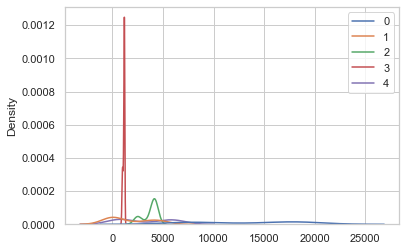

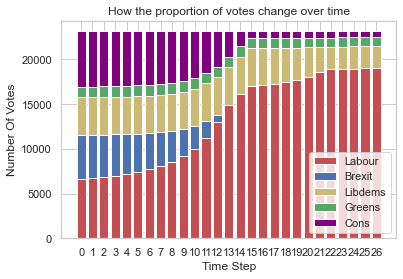

In [72]:
run(numParties, numPlayers)